In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
def candidates_in_neighbourhood(G, candidates, node):
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in sub_G.nodes() if x in candidates]
    if candidates_in_neighbourhood:
        return candidates_in_neighbourhood
    else:
        return []

In [3]:
def candidates_at_distance(dict_distances, node, d):
    return len([dist for dist in dict_distances.get(node).values() if dist == d])

In [4]:
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)
candidates = pd.read_pickle("./data/candidateGenesList_MMAF.p")

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)

candidates_MMAF = list(set([c for c in candidates if c in G.nodes()]))
nonCandidates_MMAF = [n for n in G.nodes() if n not in candidates_MMAF] 


print(f"Interactome size: {len(G.nodes())}, number of MMAF candidates in interactome: {len(candidates_MMAF)}")

Interactome size: 14465, number of MMAF candidates in interactome: 40


In [5]:
# find distances between MMAF and non-MMAF genes
dict_distances = {}
longest_distance = 0

for source_node in tqdm(nonCandidates_MMAF):
    dict_tmp = {}

    for target_node in candidates_MMAF:
        try:
            distance = nx.shortest_path_length(G, source_node, target_node)
            dict_tmp[target_node] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances[source_node] = dict_tmp

print(f"Longest distance between MMAF and non-MMAF gene: {longest_distance}")

100%|██████████| 14425/14425 [00:24<00:00, 582.34it/s]

Longest distance between MMAF and non-MMAF gene: 10


### Calculate new centrality for every non-MMAF gene

In [6]:
# set alpha parameter
alpha = 0.5

In [7]:
# calculate adjacency matrices to the powers up to longest distance between MMAF and non-MMAF genes

# create a dictionary to store matrices with structure
# {power : A^power,
# ...}
dict_adjacency = {}

# get A to the power of 1
A = nx.adjacency_matrix(G)
A_sparse = sp.sparse.csc_matrix(A.todense(), shape=A.shape)
dict_adjacency[1] = A_sparse.todense()

In [8]:
# get A to the power of 2
res = A_sparse.dot(A_sparse)
res_sparse = sp.sparse.csc_matrix(res.astype(bool).todense().astype(int))
dict_adjacency[2] = res_sparse.todense()

In [10]:
# get A to the powers of up to 4
for power in tqdm(range(3, 5)):
    res = res.dot(A_sparse)
    res_sparse = sp.sparse.csc_matrix(res.astype(bool).todense().astype(int))
    dict_adjacency[power] = res_sparse.todense()

100%|██████████| 2/2 [00:24<00:00, 12.08s/it]


In [14]:
# calculate new centrality for every non-MMAF gene
dict_scores = {}

nodes_list = list(G.nodes())

for node in tqdm(nonCandidates_MMAF):
    node_idx = nodes_list.index(node)

    score = 0
    
    for candidate in candidates_MMAF:
        candidate_idx = nodes_list.index(candidate)

        try:
            d = nx.shortest_path_length(G, node, candidate)
            
            if d > 4:
                continue
            
            else:
                A = dict_adjacency.get(d)
                score += alpha ** d * A[node_idx, candidate_idx]
        
        except:
            continue

    dict_scores[node] = score
    
dict_scores_sorted = dict(sorted(dict_scores.items(), key=lambda v: v[1], reverse=True))

  0%|          | 0/14425 [00:00<?, ?it/s]

100%|██████████| 14425/14425 [01:40<00:00, 143.54it/s]


In [15]:
dict_scores_sorted

{'ENSG00000084652': 5.625,
 'ENSG00000111057': 5.5,
 'ENSG00000178104': 5.5,
 'ENSG00000104611': 5.4375,
 'ENSG00000135249': 5.4375,
 'ENSG00000140743': 5.4375,
 'ENSG00000101004': 5.375,
 'ENSG00000171345': 5.375,
 'ENSG00000178209': 5.375,
 'ENSG00000172053': 5.3125,
 'ENSG00000068024': 5.3125,
 'ENSG00000152404': 5.3125,
 'ENSG00000077522': 5.25,
 'ENSG00000099956': 5.25,
 'ENSG00000117475': 5.25,
 'ENSG00000083535': 5.25,
 'ENSG00000078246': 5.25,
 'ENSG00000165630': 5.25,
 'ENSG00000155657': 5.1875,
 'ENSG00000100462': 5.1875,
 'ENSG00000185247': 5.1875,
 'ENSG00000101624': 5.1875,
 'ENSG00000068400': 5.1875,
 'ENSG00000166407': 5.1875,
 'ENSG00000223501': 5.1875,
 'ENSG00000166579': 5.125,
 'ENSG00000163060': 5.125,
 'ENSG00000126016': 5.125,
 'ENSG00000155875': 5.125,
 'ENSG00000204209': 5.0625,
 'ENSG00000166925': 5.0625,
 'ENSG00000068394': 5.0625,
 'ENSG00000114019': 5.0625,
 'ENSG00000117625': 5.0625,
 'ENSG00000171444': 5.0625,
 'ENSG00000205726': 5.0625,
 'ENSG00000198883'

In [16]:
# get more info about each node (degree, candidates at distances)
for n, score in dict_scores_sorted.items():
    dict_scores_sorted[n] = [round(score, 7), 
                             G.degree(n), 
                             candidates_at_distance(dict_distances, n, 1), 
                             candidates_at_distance(dict_distances, n, 2),
                             candidates_at_distance(dict_distances, n, 3),
                             candidates_at_distance(dict_distances, n, 4)]

df = pd.DataFrame.from_dict(dict_scores_sorted, 
                            orient='index', 
                            columns=['score', 'degree', 'candidates at d=1', 'candidates at d=2', 'candidates at d=3', 'candidates at d=4'])

In [17]:
# get gene names to ENSG
genes_df = pd.read_csv("./data/canonicalGenes.tsv", sep='\t')

df_res = df.merge(genes_df, left_index=True, right_on='ENSG')
df_res.sort_values(by='score', inplace=True, ascending=False)
df_res.reset_index(inplace=True, drop=True)

In [18]:
# get top 20 genes
df_top = df_res.head(20)
df_top

,score,degree,candidates at d=1,candidates at d=2,candidates at d=3,candidates at d=4,GENE,ENSG
0,5.6250,81,3,4,19,12,TXLNA,ENSG00000084652
1,5.5000,65,1,8,18,12,PDE4DIP,ENSG00000178104
2,5.5000,62,2,5,20,12,KRT18,ENSG00000111057
3,5.4375,53,1,8,17,13,SH2D4A,ENSG00000104611
4,5.4375,59,2,6,16,15,CDR2,ENSG00000140743
5,5.4375,88,2,4,22,11,RINT1,ENSG00000135249
6,5.3750,103,2,6,15,16,NINL,ENSG00000101004
7,5.3750,70,1,9,13,16,KRT19,ENSG00000171345
8,5.3750,97,1,7,19,12,PLEC,ENSG00000178209
9,5.3125,68,1,7,18,13,QARS1,ENSG00000172053


### Search for a specific gene

In [19]:
gene_of_interest = "TYMP"

score = df_res[df_res['GENE'] == gene_of_interest]['score'].values[0]

print(f"{gene_of_interest} score: {score}")

TYMP score: 3.0


### Analyze the results

<Axes: xlabel='score', ylabel='Count'>

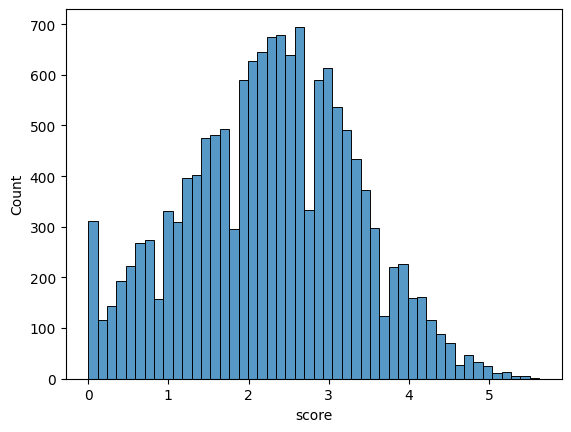

In [20]:
sns.histplot(data=df, x='score')

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='score'>

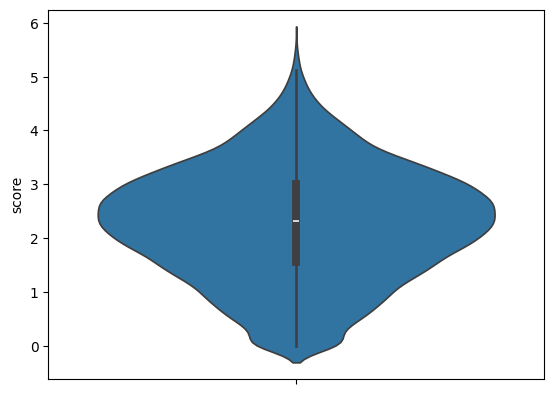

In [21]:
sns.violinplot(data=df, y='score')

### Analyze scores for new candidates from 13/02/2024

In [22]:
new_candidates = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
dict_new_candidates = dict([(gene, genes_df[genes_df['GENE'] == gene]['ENSG'].values[0]) for gene in new_candidates])

In [23]:
# check what percentage of new candidates is in interactome
len([nc for nc in dict_new_candidates.values() if nc in G.nodes()]) / len(dict_new_candidates.values())

0.68

In [24]:
# check scores of new candidates
df_new_candidates = df_res[df_res['ENSG'].isin(dict_new_candidates.values())]
df_new_candidates

,score,degree,candidates at d=1,candidates at d=2,candidates at d=3,candidates at d=4,GENE,ENSG
1795,3.5000,17,0,3,10,24,CCNA1,ENSG00000133101
3292,3.0625,11,0,3,7,23,CDC20B,ENSG00000164287
4765,2.7500,6,0,2,7,22,FAM221A,ENSG00000188732
5798,2.5625,3,0,0,10,21,SPATA6,ENSG00000132122
6883,2.3750,3,0,0,6,26,SPACA9,ENSG00000165698
7069,2.3125,7,0,1,3,27,SPATA24,ENSG00000170469
8483,2.0625,3,0,1,4,21,KIF27,ENSG00000165115
9027,1.9375,1,1,1,4,11,CCDC66,ENSG00000180376
9690,1.8125,1,0,1,2,21,FHAD1,ENSG00000142621
9812,1.8125,5,0,0,6,17,MYH7B,ENSG00000078814


/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


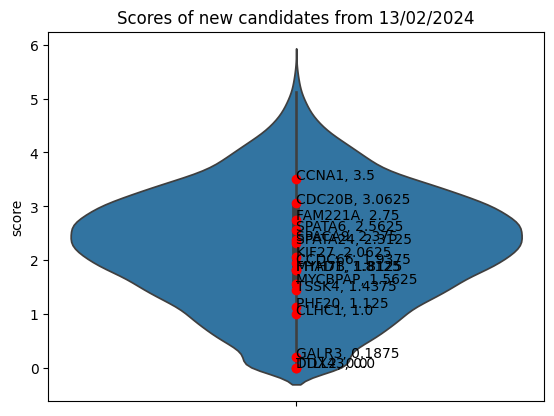

In [25]:
# plot scores of new candidates
sns.violinplot(data=df, y='score')
plt.title("Scores of new candidates from 13/02/2024")

for idx, row in df_new_candidates.iterrows():
    gene = row['GENE']
    score = row['score']
    plt.plot(score, 'or')
    plt.text(0, score, s=f"{gene}, {score}")

### Leave-one-out experiments